# SoleMate Demo

See the SoleMate pipeline in action. This notebook walks through each step:
1. Extract point clouds from both prints
2. Align them
3. Extract similarity metrics
4. Load the pre-trained model to predict if the pair is mated (both prints come from the same shoe) or non-mated (they come from different shoes)

## Imports
Assuming README installation was successful.

In [2]:
from sole import Sole
from solepair import SolePair
from solepaircompare import SolePairCompare
import pandas as pd
import pickle
import zipfile
import time

## Loading prints
Care must be taken when loading outsole scans so that extraneous parts of the image (e.g. border rulers from an Everspry Outsole Scanner) are removed before the prints are compared. For the datasets we use, a border width of 160 pixels crops out the rulers.

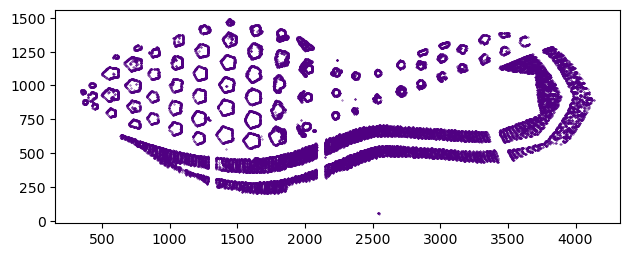

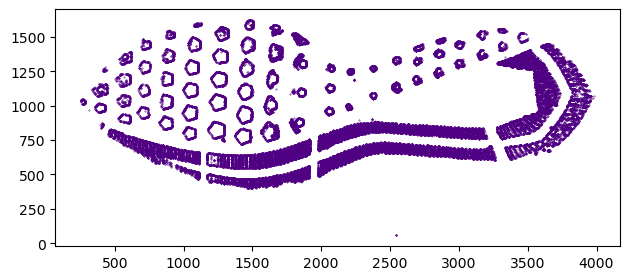

In [4]:
# load the prints (comment / uncomment the code blocks below to see mated / non-mated pairs)

# a mated pair
Q = Sole("data/demo/005772L_20180124_2_1_1_csafe_jekruse.tiff", border_width=160)
K = Sole("data/demo/005772L_20180124_2_1_2_csafe_jekruse.tiff", border_width=160)

# a non-mated pair
# Q = Sole("data/demo/058169L_20180131_2_2_2_csafe_hanrahan.tiff", border_width=160)
# K = Sole("data/demo/059518L_20180124_2_1_1_csafe_hanrahan.tiff", border_width=160)

K.plot()
Q.plot()

## Alignment
First plot the pair together unaligned, then plot them together after alignment.

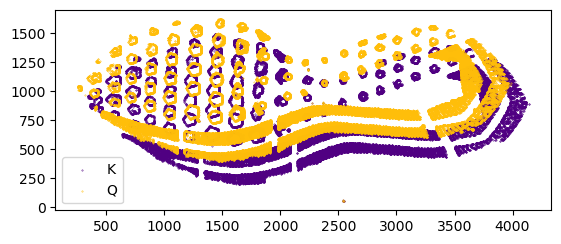

In [8]:
pair = SolePair(Q, K, mated=True)
pair.plot()

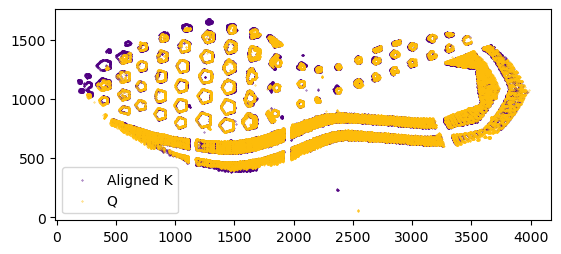

In [9]:
sc = SolePairCompare(pair, 
                     icp_downsample_rates=[0.05],
                     shift_up=True,
                     shift_down=True,
                     shift_left=True,
                     shift_right=True,
                     two_way=True) # icp is called here
pair.plot(aligned=True)

## Similarity Metric Extraction

In [10]:
# helper function for timing
def print_time(s, start):
    end = time.perf_counter()
    print(s, f"{round(end-start, 4)}s")
    return end

In [12]:
# function to extract all 35 SoleMate similarity metrics from a pair with benchmarking
def extract_metrics(Q, K):
    start = time.perf_counter();
    pair = SolePair(Q, K, mated=True)
    start = print_time("Generated pair", start)

    sc = SolePairCompare(pair, 
                     icp_downsample_rates=[0.05],
                     shift_up=True,
                     shift_down=True,
                     shift_left=True,
                     shift_right=True,
                     two_way=True) # icp is called here
    start = print_time("Aligned pair", start)
    
    # Creating a Dataframe row containing the new metrics
    dist_metrics = sc.min_dist()
    start = print_time("Calculated distance metrics", start)
    all_cluster_metrics = sc.cluster_metrics(n_clusters=20)
    start = print_time("Calculated cluster metrics (n=20)", start)
    all_cluster_metrics.update(sc.cluster_metrics(n_clusters=100))
    start = print_time("Calculated cluster metrics (n=100)", start)
    phase_correlation_metrics = sc.pc_metrics()
    start = print_time("Calculated phase correlation metrics", start)
    jaccard_index = sc.jaccard_index()
    start = print_time("Calculated jaccard index", start)

    k1 = sc.propn_overlap(threshold=1, Q_as_base=False)
    start = print_time("Calculated k1", start)
    q2 = sc.propn_overlap(threshold=2)
    start = print_time("Calculated q2", start)
    k2 = sc.propn_overlap(threshold=2, Q_as_base=False)
    start = print_time("Calculated k2", start)
    q3 = sc.propn_overlap(threshold=3)
    start = print_time("Calculated q3", start)
    k3 = sc.propn_overlap(threshold=3, Q_as_base=False)
    start = print_time("Calculated k3", start)
    q5 = sc.propn_overlap(threshold=5)
    start = print_time("Calculated q5", start)
    k5 = sc.propn_overlap(threshold=5, Q_as_base=False)
    start = print_time("Calculated k5", start)
    q10 = sc.propn_overlap(threshold=10)
    start = print_time("Calculated q10", start)
    k10 = sc.propn_overlap(threshold=10, Q_as_base=False)
    start = print_time("Calculated k10", start)

    row = {'q_pct_threshold_1': sc.propn_overlap(threshold=1),
    'k_pct_threshold_1': k1,
    'q_pct_threshold_2': q2,
    'k_pct_threshold_2': k2,
    'q_pct_threshold_3': q3,
    'k_pct_threshold_3': k3,
    'q_pct_threshold_5': q5,
    'k_pct_threshold_5': k5,
    'q_pct_threshold_10': q10,
    'k_pct_threshold_10': k10,
    'q_points_count': Q.coords.shape[0],
    'k_points_count': K.coords.shape[0]
    }
    row.update(dist_metrics)
    row.update(all_cluster_metrics)
    row.update(phase_correlation_metrics)
    row.update(jaccard_index)
    row = pd.DataFrame(row, index=[0])
    return row

In [28]:
# extract metrics from our pair
metrics = extract_metrics(Q, K)

Generated pair 0.0s
Aligned pair 3.7286s
Calculated distance metrics 0.6503s


/home/simon/miniconda3/envs/solemate/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Calculated cluster metrics (n=20) 1.4319s


/home/simon/miniconda3/envs/solemate/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Calculated cluster metrics (n=100) 1.3725s
Calculated phase correlation metrics 1.8129s
Calculated jaccard index 0.1718s
Calculated k1 1.0082s
Calculated q2 1.0378s
Calculated k2 1.0054s
Calculated q3 1.0759s
Calculated k3 1.0524s
Calculated q5 1.1425s
Calculated k5 1.186s
Calculated q10 1.3953s
Calculated k10 1.4202s


In [15]:
# look at the metrics
metrics

,q_pct_threshold_1,k_pct_threshold_1,q_pct_threshold_2,k_pct_threshold_2,q_pct_threshold_3,k_pct_threshold_3,q_pct_threshold_5,k_pct_threshold_5,q_pct_threshold_10,k_pct_threshold_10,...,iterations_k_n_clusters_100,wcv_ratio_n_clusters_100,peak_value,MSE,SSIM,PSR,NCC,jaccard_index_0,jaccard_index_-1,jaccard_index_-2
0,0.252643,0.250522,0.442147,0.43738,0.621804,0.613887,0.842771,0.838999,0.971741,0.956102,...,13,-0.055319,279087300.0,829.336829,0.88674,13.04136,0.085124,0.039499,0.624871,0.914706


## Load pre-trained model

In [3]:
# load in the proposed model (Full without indicator)

def load_everything_model():
    with zipfile.ZipFile("static/EVERYTHING_TO_EVERYTHING_NOIND.pkl.zip", 'r') as zip_ref:
        zip_ref.extract("EVERYTHING_TO_EVERYTHING_NOIND.pkl", "static/")
    with open('static/EVERYTHING_TO_EVERYTHING_NOIND.pkl', 'rb') as p:
        return pickle.load(p)
rf_model = load_everything_model()

/home/simon/miniconda3/envs/solemate/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/simon/miniconda3/envs/solemate/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
# use it to predict if the pair is mated or not based on the similarity metrics
metrics = metrics[list(rf_model.feature_names_in_)]
score = rf_model.predict_proba(metrics)[0][1]
print(f"Model Predicts Q and K are mated with a probability of: {score}")

Model Predicts Q and K are mated with a probability of: 0.907
